In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import scipy as sp

np.set_printoptions(precision=5, suppress=True)

import gzip
import os
import pdb
import pickle

seed = 1

np.random.seed(seed)
threads = 1
os.environ['STAN_NUM_THREADS'] = str(threads)

In [2]:
n_N = 500
n_F = 5
n_Y = 10
n_D = 2000
n_W = 1000
n_C = 4
AD = 0.95

Y = np.zeros((n_N, n_Y))
B = np.zeros((n_Y, n_F))
log_F_sigma = np.zeros((n_F))

# y hyperparameters
log_y_sigma = np.random.normal(0, 0.25) * np.ones(n_Y)

# f hyperparameters
log_f_sigma = np.zeros((n_F))
# diag chol
# chol_log_f_sigma = np.diag(np.abs(np.random.normal(0, 0.1, n_F)))
# full chol
# chol_log_f_sigma = np.random.normal(0, 1, n_F * n_F).reshape(n_F, n_F)
# row, col = np.diag_indices(n_F)
# chol_log_f_sigma[row, col] = np.abs(chol_log_f_sigma[row, col])

# B
# base_order = 1
base_order = 0.05
bias_order = 0.5
p_connect = 0.3
n_connect = np.int(p_connect * n_Y * n_F)
add = (2 * np.random.binomial(1, 0.5, n_connect) - 1) * (bias_order + np.abs(np.random.standard_normal(n_connect)))
B_ = base_order * np.random.standard_normal(n_Y * n_F)
B_[:n_connect] = B_[:n_connect] + add
B_ = np.random.permutation(B_).reshape(n_Y, n_F)
row, col = np.triu_indices(n_Y, 0, n_F)
B_[row, col] = 0
np.fill_diagonal(B_, 1)

# Initialise
log_F_sigma = log_f_sigma # chol_log_f_sigma @ np.random.standard_normal(n_F) 
B = B_ # + base_order * np.tril(np.random.standard_normal(n_Y * n_F).reshape(n_Y, n_F), k=-1)

for i in range(1, n_N):
    Y[i] = B @ (np.exp(log_F_sigma) * np.random.standard_normal(n_F)) + np.exp(log_y_sigma) * np.random.standard_normal(n_Y)

dat = {
    'P': n_Y,
    'N': n_N,
    'D': n_F,
    # 'fac_mu': np.zeros(n_F),
    'y': Y
    }

In [3]:
extra_compile_args = ['-pthread', '-DSTAN_THREADS']
model = pystan.StanModel(file='infer.stan', extra_compile_args=extra_compile_args)
fit = model.sampling(data=dat, iter=n_D, warmup=n_W, seed=seed, chains=n_C, control={'adapt_delta':AD}, n_jobs=threads)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18ba64d933486dd9fc408ae85dbcdf47 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [4]:
res = fit.extract(pars=['beta', 'fac'])

beta = B.flatten()
beta_hat = np.mean(res['beta'], axis=0).flatten()

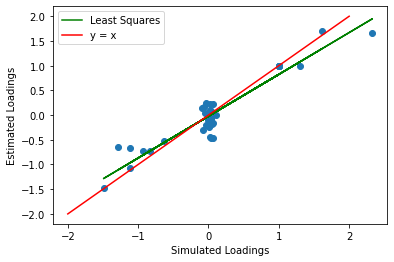

In [7]:
plt.scatter(beta, beta_hat)
m, b, _, _, _ = sp.stats.linregress(beta, beta_hat)
plt.plot(beta, b + m * beta, '-', color='g', label='Least Squares')
plt.plot([-2, 2], [-2, 2], color='r', label='y = x')
plt.xlabel('Simulated Loadings')
plt.ylabel('Estimated Loadings')
plt.legend()